<h1 align="center">Level and Group Classification on Train and Test Datasets</h1>

We have two classification tasks:

* Predict the level, which ranges from 1-16.
* Predict the group of a given text, given this mapping from levels to group:
  - Levels 1-3 = Group A1
  - Levels 4-6 = Group A2
  - Levels 7-9 = Group B1
  - Levels 10-12 = Group B2
  - Levels 13-15 = Group C1
  - Levels 16 = Group C2

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd 
import numpy as np
import seaborn as sns

Here, we load the DataFrame for the full training set and repeat the classification approach identified in step 2.

In [2]:
%%time
raw_input = pd.read_pickle('train_full.pkl')

CPU times: user 368 ms, sys: 268 ms, total: 636 ms
Wall time: 636 ms


In [3]:
raw_input.head()

,article_id,grade,level,text,topic_id,topic_text,unit,group
1009674,1034964,95,3,In Rio I recommend the Copacabana Palace Hotel...,19,Renovating your home,3,A1
98801,100816,88,2,"Hi, I'm Arielle from Brazil. I speak portugues...",15,Writing a personal profile,7,A1
1013567,1038947,70,3,In my country.Living cost is going up. housing...,21,Giving suggestions about clothing,5,A1
891706,913874,90,3,"In my country, the price going up. I live in S...",21,Giving suggestions about clothing,5,A1
747383,765853,95,2,Dear don't be unhappy.You should play cards wi...,10,Writing a birthday invitation,2,A1


In [4]:
raw_input.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 944247 entries, 1009674 to 275300
Data columns (total 8 columns):
article_id    944247 non-null int64
grade         944247 non-null int64
level         944247 non-null int64
text          944247 non-null object
topic_id      944247 non-null int64
topic_text    944247 non-null object
unit          944247 non-null int64
group         944247 non-null object
dtypes: int64(5), object(3)
memory usage: 64.8+ MB


# Check for Class Imbalance

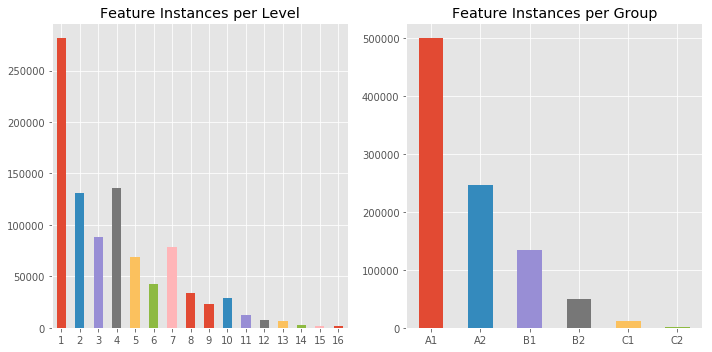

In [5]:
level_counts = raw_input.level.value_counts().sort_index()
group_counts = raw_input.group.value_counts().sort_index()

_, ax = plt.subplots(1, 2, figsize=(10, 5))

_ = level_counts.plot(kind='bar', title='Feature Instances per Level', ax=ax[0], rot=0)
_ = group_counts.plot(kind='bar', title='Feature Instances per Group', ax=ax[1], rot=0)

plt.tight_layout()

# Level Classification Based on Text

Here we apply the same approach of converting text to bag-of-words features and then using a maximum entropy classifier. The difference is we are now running on the full dataset which is much larger. The optimizer now requires more steps to converge, so we change the `max_iters` attribute of `LogisticRegression` to 1000. We address the label imbalance by setting `class_weight='balanced'`.

In [6]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

en_stopwords = set(stopwords.words('english'))
print(en_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
{'have', 'those', 'over', 'o', 'ma', 'theirs', 'had', "needn't", "you'd", 'yourself', 'a', 'such', 'wasn', 'did', 'of', 'whom', 'them', "won't", "don't", 'which', 'no', 'on', 'doing', 'its', 'haven', 'through', "doesn't", "couldn't", 'below', 'll', 'mustn', 'that', 'him', 'do', "should've", 'above', 'just', 'but', 'themselves', 'here', 'yours', "mustn't", "hasn't", 'before', 'does', 'y', 'at', 'until', 'hers', 'own', 'further', 'hadn', 'any', 'who', 'i', 'other', 'been', 'has', 'down', 'am', 'than', "you're", 've', "aren't", 'weren', 'only', 'then', 'same', 'both', 'not', 'too', "haven't", 'should', 'these', 'out', 'isn', 'couldn', 'myself', 'between', 'how', 'he', 'ourselves', 'or', 'mightn', 'herself', 'so', 'it', 'were', 'h

In [7]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


def display_results(y, y_pred):
    """Given some predications y_pred for a target label y, 
    display the precision/recall/f1 score and the confusion matrix."""
        
    report = classification_report(y_pred, y)
    print(report)

    level_values = y.unique()
    level_values.sort()
    cm = confusion_matrix(y_true=y, y_pred=y_pred.values, labels=level_values)
    cm = pd.DataFrame(index=level_values, columns=level_values, data=cm)

    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    ax = sns.heatmap(cm, annot=True, ax=ax, fmt='d')

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold

def build_pipeline():
    """Return the combination of a Feature Extractor and a LogisticRegression model in a ``Pipeline``. """
    
    counter = CountVectorizer(
        lowercase=True, 
        stop_words=en_stopwords, 
        ngram_range=(1, 1),
        min_df=5,
        max_df=0.4,
        binary=True)

    model = LogisticRegression(
         # maximize log-likelihood + square norm of parameters
        penalty='l2',
        # steps required for the L-BFGS optimizer to converge, found by trial and error
        max_iter=1000, 
        # use softmax instead of one-vs-rest style classification
        multi_class='multinomial', 
        # use L-BFGS optimizer 
        solver='lbfgs',
        # This prints out a warning if the optimizer hasn't converged
        verbose=True, 
        # to handle the class imbalance
        # automatically adjust weights inversely proportional to 
        # class frequencies in the input data
        class_weight='balanced', 
        random_state=4321)
    
    pipeline = make_pipeline(counter, model)
    return pipeline
    

def classify(input_df, target_label='level'):
    """
    Build a classifier for the `target_label` column in the DataFrame `input_df` using the `text` column.    
    Return the (labels, predicted_labels) tuple.    
    Use a 10-fold Stratified K-fold cross-validator to generate the out-of-sample predictions."""
    
    assert target_label in input_df.columns
    
    pipeline = build_pipeline()    
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

    X = input_df.text
    y = input_df.loc[:, target_label]
    y_pred = cross_val_predict(pipeline, X=X.values, y=y.values, cv=cv, n_jobs=10, verbose=2)
    y_pred = pd.Series(index=input_df.index.copy(), data=y_pred)

    return y.copy(), y_pred

In [9]:
%%time
levels, levels_predicted = classify(raw_input, target_label='level')

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 27.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 27.5min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 27.9min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 28.1min finished
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed: 28.8min remaining: 67.2min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 28.2min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 28.4min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 28.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 28.4min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 28.5min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 28.4min finished


CPU times: user 9.23 s, sys: 6.13 s, total: 15.4 s
Wall time: 29min 30s


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 29.5min finished


             precision    recall  f1-score   support

          1       0.97      0.98      0.98    279800
          2       0.96      0.96      0.96    131874
          3       0.94      0.93      0.94     88792
          4       0.95      0.97      0.96    133638
          5       0.94      0.94      0.94     68754
          6       0.94      0.93      0.94     42836
          7       0.94      0.95      0.95     77351
          8       0.90      0.87      0.88     34512
          9       0.92      0.90      0.91     23386
         10       0.94      0.94      0.94     29170
         11       0.87      0.84      0.86     12901
         12       0.90      0.87      0.88      7654
         13       0.91      0.89      0.90      7182
         14       0.84      0.81      0.83      2995
         15       0.73      0.72      0.73      1826
         16       0.80      0.79      0.80      1576

avg / total       0.95      0.95      0.95    944247



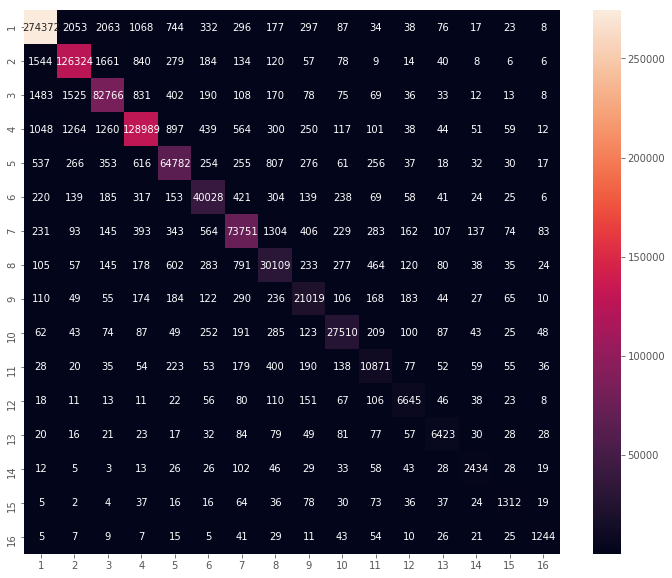

In [11]:
display_results(levels, levels_predicted)

# Group Classification Based on Text

In [12]:
%%time
groups, groups_predicted = classify(raw_input, target_label='group')

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 20.7min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 20.7min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 20.9min finished
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed: 21.9min remaining: 51.1min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 21.3min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 21.6min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 21.6min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 21.7min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 21.9min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 21.9min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 22.0min finished


CPU times: user 9.89 s, sys: 5.76 s, total: 15.7 s
Wall time: 23min 9s


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 23.1min finished


In [ ]:
display_results(groups, groups_predicted)

# Classification on Test Set

Finally we report the performance on our classfier on both the `leve` and `group` classification tasks using the test dataset. For this we re-build the model using the hyperparameters used above, and train it using the entire train dataset.

In [19]:
from functools import lru_cache

@lru_cache(maxsize=1)
def get_test_dataset():
    return pd.read_pickle('test.pkl')


def report_test_perf(train_df, target_label='level'):
    """Produce classification report and confusion matrix on the test Dataset for a given ``target_label``."""
    test_df = get_test_dataset()
    
    assert target_label in train_df.columns
    assert target_label in test_df.columns
    
    # Train the model using the entire training dataset
    pipeline = build_pipeline()    
    X_train, y_train = train_df.text, train_df.loc[:, target_label]
    pipeline = pipeline.fit(X_train.values, y_train.values)
                            
    # Generate predictions using test data
    X_test, y_test = test_df.text, test_df.loc[:, target_label]
    predicted = pipeline.predict(X_test.values)
                            
    predicted = pd.Series(index=test_df.index, 
                          data=predicted, 
                          name='{}_pred'.format(target_label))
                            
    display_results(y_test, predicted)
    

## Level Classification on Test Set

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.7min finished


             precision    recall  f1-score   support

          1       0.97      0.98      0.98     69973
          2       0.96      0.96      0.96     32966
          3       0.94      0.93      0.94     22245
          4       0.95      0.97      0.96     33412
          5       0.95      0.94      0.94     17268
          6       0.95      0.93      0.94     10754
          7       0.94      0.96      0.95     19290
          8       0.89      0.87      0.88      8550
          9       0.91      0.90      0.91      5800
         10       0.95      0.94      0.95      7324
         11       0.88      0.85      0.86      3232
         12       0.89      0.87      0.88      1896
         13       0.89      0.89      0.89      1769
         14       0.83      0.80      0.81       750
         15       0.76      0.77      0.77       442
         16       0.80      0.80      0.80       391

avg / total       0.95      0.95      0.95    236062



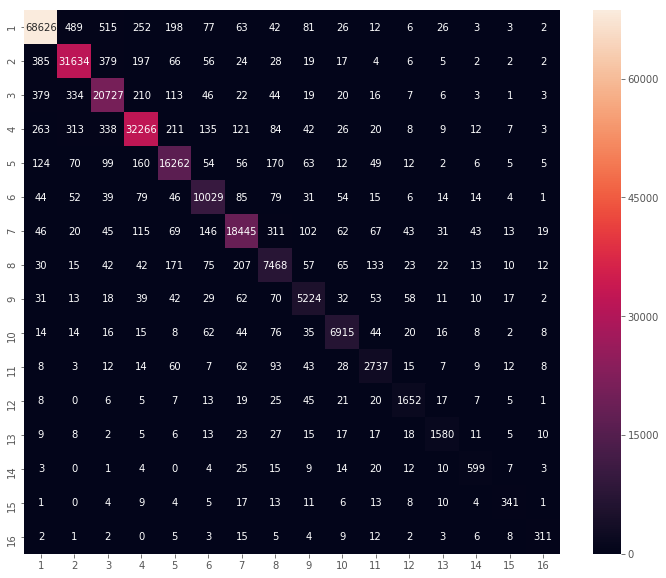

In [21]:
%% time

train_df = raw_input
report_test_perf(train_df, 'level')

## Group Classification on Test Set

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.1min finished


             precision    recall  f1-score   support

         A1       0.98      0.99      0.98    124702
         A2       0.95      0.95      0.95     61427
         B1       0.94      0.94      0.94     33760
         B2       0.92      0.90      0.91     12650
         C1       0.88      0.82      0.85      3135
         C2       0.78      0.78      0.78       388

avg / total       0.96      0.96      0.96    236062

CPU times: user 46min 50s, sys: 2min 39s, total: 49min 30s
Wall time: 9min 53s


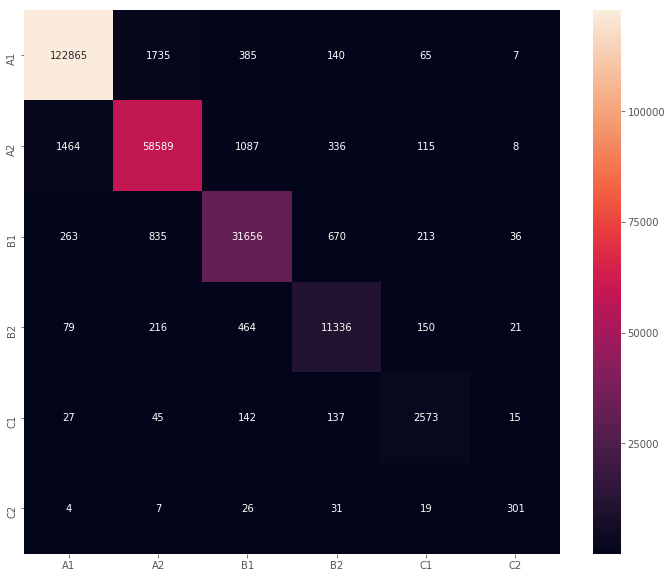

In [23]:
%%time

report_test_perf(train_df, 'group')